In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys,os

import numpy as np
import matplotlib.pyplot as plt

import glob
import xarray as xr
import datetime

In [2]:
# import yaml
import tqdm
import torch
import pickle
import logging
import random

from typing import List, Dict, Callable, Union, Any, TypeVar, Tuple
# from multiprocessing import cpu_count


import torch
import torch.fft
from torch import nn

import torch.nn.functional as F

# from torchvision.utils import save_image
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [3]:
is_cuda = torch.cuda.is_available()
device = torch.device(torch.cuda.current_device()) if is_cuda else torch.device("cpu")

if is_cuda:
    torch.backends.cudnn.benchmark = True

print(f'Preparing to use device {device}')

Preparing to use device cuda:0


In [4]:
dtype = torch.complex64  # fft required data type

In [5]:
def torch_holo_set(Ein:torch.tensor,fx:torch.tensor,fy:torch.tensor,z_tnsr:torch.tensor,lam:float):
    """
    Propagates an electric field a distance z
    Ein complex torch.tensor
    - input electric field
    
    fx:real torch.tensor
    - x frequency axis (3D, setup to broadcast)
    
    fy: real torch.tensor
    - y frequency axis (3D, setup to broadcast)
    
    z_tnsr: torch.tensor
    - tensor of distances to propagate the wave Ein
        expected to have dims (Nz,1,1) where Nz is the number of z
        dimensions
    
    lam: float
    - wavelength
    
    returns: complex torch.tensor with dims (Nz,fy,fx)
    
    Note the torch.fft library uses dtype=torch.complex64
    This may be an issue for GPU implementation
    
    """
    Etfft = torch.fft.fft2(Ein)
#     Eofft = Etfft*torch.cos(2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    Eofft = Etfft*torch.exp(1j*2*np.pi*z_tnsr/lam*torch.sqrt(1-lam**2*(fx**2+fy**2)))
    
    # It might be helpful if we could omit this step.  It would save an inverse fft.
    Eout = torch.fft.ifft2(Eofft)
    
    return Eout

# Pick the Dataset

In [6]:
data_dir = '/glade/p/cisl/aiml/ai4ess_hackathon/holodec/'

In [7]:
file_list = glob.glob(data_dir+'*.nc')
for f_idx,file in enumerate(file_list):
    print(f'{f_idx}.) '+file.split('/')[-1])

0.) synthetic_holograms_7particle_gamma_600x400_training.nc
1.) synthetic_holograms_10particle_gamma_512x512_validation_patches128x128.nc
2.) synthetic_holograms_50-100particle_bidisperse_test.nc
3.) synthetic_holograms_multiparticle_validation.nc
4.) synthetic_holograms_1particle_training_small.nc
5.) synthetic_holograms_6particle_gamma_600x400_test.nc
6.) synthetic_holograms_multiparticle_training.nc
7.) synthetic_holograms_50-100particle_gamma_private.nc
8.) synthetic_holograms_12-25particle_gamma_600x400_validation.nc
9.) synthetic_holograms_6particle_gamma_600x400_training.nc
10.) synthetic_holograms_50-100particle_gamma_training.nc
11.) synthetic_holograms_1particle_gamma_600x400_training.nc
12.) synthetic_holograms_4particle_gamma_600x400_validation.nc
13.) synthetic_holograms_3particle_validation.nc
14.) synthetic_holograms_10particle_gamma_600x400_test.nc
15.) synthetic_holograms_1particle_gamma_600x400_validation.nc
16.) synthetic_holograms_10particle_gamma_600x400_training.n

In [8]:
f_sel = 30
dataFile = file_list[f_sel]

In [9]:
h_ds = xr.open_dataset(dataFile)

# Build Histogram For Labels

In [10]:
n_bins = 10000  # number of bins in histogram
n_holograms = 200  # number of holograms to use in data set
z_bins = np.linspace(h_ds.attrs['zMin'],h_ds.attrs['zMax'],n_bins)*1e6  # histogram bin edges
z_centers = z_bins[:-1] + 0.5*np.diff(z_bins)  # histogram bin centers
hologram_slice = slice(None,2*n_holograms)

In [11]:
histogram_lst = []
for holo_idx in h_ds['hologram_number'].values[hologram_slice]:
    hist_tpl = np.histogram(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],bins=z_bins)
    histogram_lst.append(hist_tpl[0])

Text(0.5, 0, 'z position [$\\mu m$]')

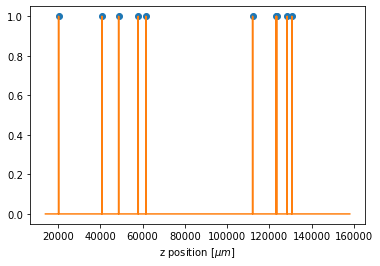

In [12]:
# confirm histogram and particle data are aligned
plt.figure()
plt.plot(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)],np.ones(h_ds['z'].values[np.where(h_ds['hid'].values==holo_idx+1)].shape),'o')
plt.plot(z_centers,histogram_lst[holo_idx])
plt.xlabel('z position [$\mu m$]')

In [13]:
histogram_arr = np.stack(histogram_lst,axis=0)
train_histogram_bin_arr = (histogram_arr[:n_holograms,:]>0).astype(float)
valid_histogram_bin_arr = (histogram_arr[n_holograms:,:]>0).astype(float)

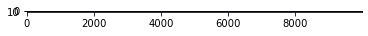

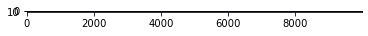

In [14]:
plt.figure()
plt.imshow(histogram_arr[0:20,:])
plt.figure()
plt.imshow(train_histogram_bin_arr[0:20,:])

# Build Reconstructed Plane Inputs

In [55]:
dx = h_ds.attrs['dx']      # horizontal resolution
dy = h_ds.attrs['dy']      # vertical resolution
Nx = int(h_ds.attrs['Nx']) # number of horizontal pixels
Ny = int(h_ds.attrs['Ny']) # number of vertical pixels
lam = h_ds.attrs['lambda'] # wavelength
zMin = h_ds.attrs['zMin']  # minimum z in sample volume
zMax = h_ds.attrs['zMax']  # maximum z in sample volume
zCCD = 0                   # z position of the image plane
num_per_holo = 3
image_norm = 255.0

In [16]:
x_arr = np.arange(-Nx//2,Ny//2)*dx
y_arr = np.arange(-Ny//2,Ny//2)*dy

In [17]:
fx = torch.fft.fftfreq(Nx,dx,device=device)[None,:,None]
fy = torch.fft.fftfreq(Ny,dy,device=device)[None,None,:]
z_rec = torch.tensor(z_centers*1e-6,device=device)[:,None,None]

Test Reconstruction Assumptions

(10, 512, 512)
(512,)
(512,)


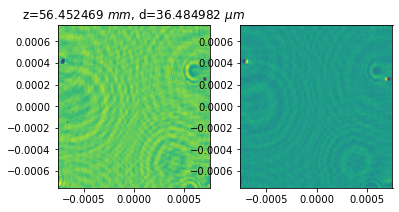

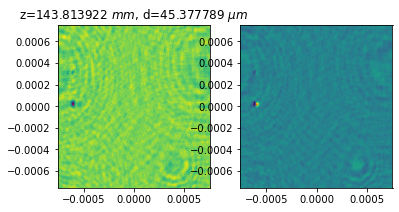

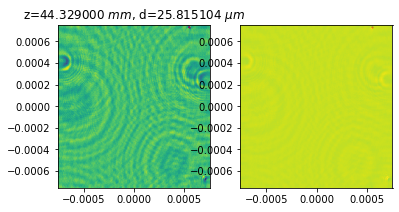

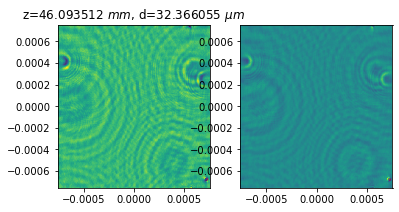

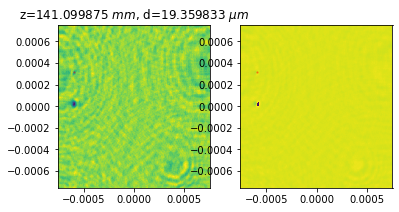

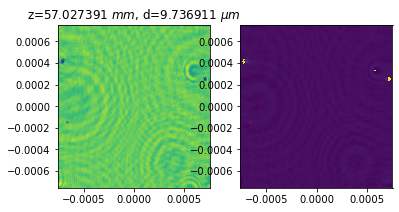

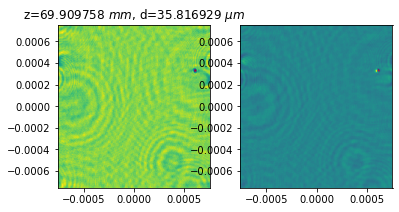

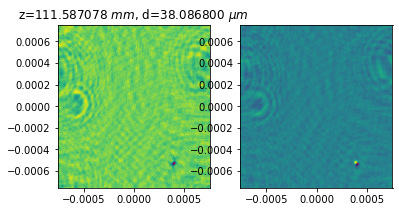

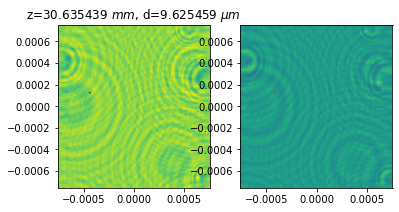

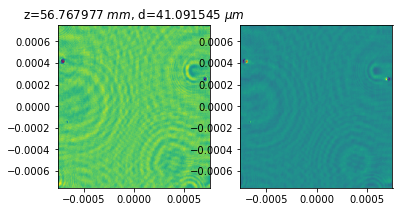

In [18]:
holo_idx = 0
p_idx = np.where(h_ds['hid'].values==holo_idx+1)[0]
xp = h_ds['x'].values[p_idx]
yp = h_ds['y'].values[p_idx]
zp = h_ds['z'].values[p_idx]
dp = h_ds['d'].values[p_idx]
z_plane = torch.tensor(zp*1e-6,device=device)[:,None,None]
E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
Eres = torch_holo_set(E_input,fx,fy,z_plane,lam).detach().cpu().numpy()

print(Eres.shape)
print(x_arr.shape)
print(y_arr.shape)

for idx,z in enumerate(zp):
    fig,ax = plt.subplots(1,2,figsize=(6,3))
    ax[0].pcolormesh(x_arr,y_arr,np.abs(Eres[idx,:,:]))
    ax[0].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)
    ax[0].set_title('z=%f $mm$, d=%f $\mu m$'%(z*1e-3,dp[idx]))
    ax[1].pcolormesh(x_arr,y_arr,np.angle(Eres[idx,:,:]))
    ax[1].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)

In [56]:
Eset = []
histset = []
start_time = datetime.datetime.now()
for holo_idx in range(2*n_holograms):
    part_idx = np.where(histogram_arr[holo_idx,:] > 0)[0]
    empt_idx = np.where(histogram_arr[holo_idx,:] == 0)[0]
    set_part = np.random.choice(part_idx, num_per_holo ,replace=False)
    set_empt = np.random.choice(empt_idx, num_per_holo ,replace=False)
    z_rec_sub = torch.tensor(1e-6*z_centers[np.concatenate([set_part,set_empt])],device=device)[:,None,None]
    E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values/image_norm,device=device,dtype=dtype)[None,:,:] 
    Eres = torch_holo_set(E_input,fx,fy,z_rec_sub,lam).detach().cpu()
#     Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))
    Eset.append(torch.stack([Eres.abs(),Eres.angle()],dim=1))
    histset.append(histogram_arr[holo_idx,np.concatenate([set_part,set_empt])])

#     # Include All Reconstructions
#     E_input = torch.tensor(h_ds['image'].isel(hologram_number=holo_idx).values,device=device,dtype=dtype)[None,:,:] 
#     Eres = torch_holo_set(E_input,fx,fy,z_rec,lam).detach().cpu()
#     Eset.append(torch.stack([Eres.abs(),Eres.angle()],dim=1))
#     # Eset.append(torch.stack([Eres.real,Eres.imag],dim=1))


end_time = datetime.datetime.now()

In [57]:
exec_time = end_time-start_time
print(f'executed {2*num_per_holo*len(Eset)} planes in {exec_time.total_seconds()} seconds')
print(f' for {exec_time.total_seconds()/(2*num_per_holo*len(Eset))} seconds per plane')

# exec_time = end_time-start_time
# print(f'executed {z_centers.size*len(Eset)} planes in {exec_time.total_seconds()} seconds')
# print(f' for {exec_time.total_seconds()/(z_centers.size*len(Eset))} seconds per plane')

executed 2400 planes in 23.409432 seconds
 for 0.00975393 seconds per plane


In [58]:
train_inputs = torch.cat(Eset[:n_holograms],dim=0)
valid_inputs = torch.cat(Eset[n_holograms:],dim=0)

In [59]:
hist_labels = np.concatenate(histset)

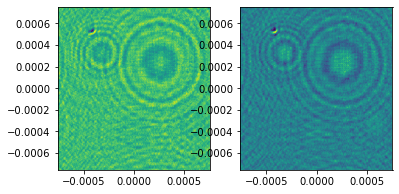

In [60]:
idx = np.where(hist_labels>0)[0][84]
fig,ax = plt.subplots(1,2,figsize=(6,3))
# ax[0].pcolormesh(x_arr,y_arr,Eset[1][0,0,:,:])
ax[0].pcolormesh(x_arr,y_arr,train_inputs[idx,0,:,:])
#     ax[0].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)
#     ax[0].set_title('z=%f $mm$, d=%f $\mu m$'%(z*1e-3,dp[idx]))
# ax[1].pcolormesh(x_arr,y_arr,Eset[1][0,1,:,:])
ax[1].pcolormesh(x_arr,y_arr,train_inputs[idx,1,:,:])
#     ax[1].scatter(yp[idx]*1e-6,xp[idx]*1e-6,c='r',s=2,alpha=0.3)

In [62]:
train_inputs.max()

tensor(3.1416, dtype=torch.float64)

# Build Model

In [63]:
epochs = 30
optimizer_type = "adam"
learning_rate = 1e-4
batch_size = 64
dtype = torch.float

In [64]:
# train_labels = torch.tensor(train_histogram_bin_arr.reshape(-1,1),dtype=dtype)
# valid_labels = torch.tensor(valid_histogram_bin_arr.reshape(-1,1),dtype=dtype)

# ### TODO ###
train_labels = torch.tensor(hist_labels[:2*n_holograms*num_per_holo],dtype=dtype)[:,None]
valid_labels = torch.tensor(hist_labels[2*n_holograms*num_per_holo:],dtype=dtype)[:,None]

In [65]:
train_labels.shape

torch.Size([1200, 1])

In [66]:
# loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.BCELoss()

In [67]:
input_shape = train_inputs.shape[1:]
output_shape = train_labels.shape[1:]
print(input_shape)
print(output_shape)

torch.Size([2, 512, 512])
torch.Size([1])


In [68]:
# ResNet 50 notebook : /glade/work/schreck/repos/goes16ci/gunther_notebook/latest.ipynb

class z_plane_histogram_cnn(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 32, 7)
        self.pool = nn.MaxPool2d(4, 4)
        self.conv2 = nn.Conv2d(32, 64, 7)
        self.fc1 = nn.Linear(64*30*30, 120)
        self.fc2 = nn.Linear(120, 1)
#         self.fc3 = nn.Linear(84, 1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
#         print(x.shape)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
#         x = F.sigmoid(self.fc3(x))
        return x
    
#     def __init__(self,in_shape,out_shape,cnn_layer_count,layer_nodes):
#         """
#         in_size: int
#             size of inputs tensor
#         out_shape: tuple
#             shape of the output tensor
#         """
#         super(plane_histogram_cnn, self).__init__()
        
    
        
        
# #         self.out_shape = out_shape
# #         out_size = np.prod(out_shape)

# #         # create a list of the CNN layers
# #         self.layer_lst = nn.ModuleList()
# #         for idx,node_count in range(cnn_layer_nodes):
# #                 self.layer_lst.append(nn.Conv2d(2, 4, 5))  # (in channels, out channels, size)
# #                 self.layer_lst.append(nn.MaxPool2d(2, 2))  # (kernel size , stride)
        
# #         self.layer_lst.append(nn.Flatten())       
                
# #         for idx, node_count in enumerate(layer_nodes)
# #             self.layer_lst.append(nn.Linear(layer_nodes[idx-1],node_count))
            
# #         self.layer_lst.append(nn.Linear(layer_nodes[-1],out_size))
        
# #         self.activation = nn.ReLU()
# #         self.output_activation = nn.Sigmoid() # nn.ReLU() #nn.Sigmoid()
 
#     def forward(self, x):
#         for layer in self.layer_lst[:-1]:
#             x = self.activation(layer(x))
#         output = self.output_activation(self.layer_lst[-1](x))

#         return output

In [69]:
cnn_model = z_plane_histogram_cnn()
cnn_model.to(device)

z_plane_histogram_cnn(
  (conv1): Conv2d(2, 32, kernel_size=(7, 7), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(7, 7), stride=(1, 1))
  (fc1): Linear(in_features=57600, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=1, bias=True)
)

In [70]:
if optimizer_type == "adam":
    optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)
elif optimizer_type == "sgd":
    optimizer = torch.optim.SGD(cnn_model.parameters(), lr=learning_rate)
else:
    logging.warning(
        f"Optimzer type {optimizer_type} is unknown. Exiting with error."
    )

In [71]:
train_ds = TensorDataset(train_inputs.float().to(device), train_labels.float().to(device))
train_dl = DataLoader(train_ds, batch_size=batch_size,shuffle=True)

valid_ds = TensorDataset(valid_inputs.float().to(device), valid_labels.float().to(device))
valid_dl = DataLoader(valid_ds, batch_size=batch_size)

In [72]:
batches_per_epoch = len(train_dl)
train_loss_hist = []
valid_loss_hist = []

for epoch in range(epochs):
    train_loss = 0
    cnn_model.train()
    for batch_idx,(xb,yb) in tqdm.tqdm(enumerate(train_dl),total=batches_per_epoch,leave=True):
        pred = cnn_model(xb)
        loss = loss_fn(pred, yb)
        train_loss += loss.sum().to('cpu').item()

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        cnn_model.eval()
    with torch.no_grad():
        valid_loss = sum(loss_fn(cnn_model(xb), yb) for xb, yb in valid_dl)

    train_loss_hist += [train_loss / len(train_dl)]
    valid_loss_hist += [valid_loss.item() / len(valid_dl)]
    print(epoch, train_loss / len(train_dl), valid_loss.item() / len(valid_dl))

 11%|█         | 2/19 [00:00<00:00, 18.49it/s]

0 0.7143031829281857 0.7002113743832237


 11%|█         | 2/19 [00:00<00:00, 18.48it/s]

1 0.6976907253265381 0.6970165152298776


 11%|█         | 2/19 [00:00<00:00, 18.45it/s]

2 0.6917585887407002 0.6958396811234323


 11%|█         | 2/19 [00:00<00:00, 18.41it/s]

3 0.6904794511042143 0.6945430856002005


 11%|█         | 2/19 [00:00<00:00, 18.41it/s]

4 0.6875427741753427 0.695557995846397


 11%|█         | 2/19 [00:00<00:00, 18.48it/s]

5 0.6860016396171168 0.6978643316971628


 11%|█         | 2/19 [00:00<00:00, 18.54it/s]

6 0.6842045282062731 0.6937324122378701


 11%|█         | 2/19 [00:00<00:00, 18.40it/s]

7 0.6792378111889488 0.6978519841244346


 11%|█         | 2/19 [00:00<00:00, 18.40it/s]

8 0.6783584795500103 0.700042021901984


 11%|█         | 2/19 [00:00<00:00, 18.52it/s]

9 0.6727326292740671 0.6958840018824527


 11%|█         | 2/19 [00:00<00:00, 18.43it/s]

10 0.6686856715302718 0.6996681313765677


 11%|█         | 2/19 [00:00<00:00, 18.46it/s]

11 0.6647722438762063 0.6979990005493164


 11%|█         | 2/19 [00:00<00:00, 18.41it/s]

12 0.6578682912023444 0.7019669382195723


 11%|█         | 2/19 [00:00<00:00, 18.51it/s]

13 0.6540810810892206 0.7142396726106343


 11%|█         | 2/19 [00:00<00:00, 18.35it/s]

14 0.6508077665379173 0.7308841504548725


 11%|█         | 2/19 [00:00<00:00, 18.37it/s]

15 0.6464722407491583 0.705874292474044


 11%|█         | 2/19 [00:00<00:00, 18.40it/s]

16 0.640211538264626 0.7222821085076583


 11%|█         | 2/19 [00:00<00:00, 17.95it/s]

17 0.63695186062863 0.7155634729485763


 11%|█         | 2/19 [00:00<00:00, 18.23it/s]

18 0.6328100624837374 0.7294595617997018


 11%|█         | 2/19 [00:00<00:00, 17.18it/s]

19 0.6248594020542345 0.7483237919054533


 11%|█         | 2/19 [00:00<00:00, 18.18it/s]

20 0.625168430177789 0.7379640779997173


 11%|█         | 2/19 [00:00<00:00, 18.38it/s]

21 0.6196391582489014 0.7422922535946495


 11%|█         | 2/19 [00:00<00:00, 18.45it/s]

22 0.613816499710083 0.8671255613628187


 11%|█         | 2/19 [00:00<00:00, 18.38it/s]

23 0.6159833795145938 0.7443332672119141


 11%|█         | 2/19 [00:00<00:00, 18.34it/s]

24 0.6069903561943456 0.7637417943854081


 11%|█         | 2/19 [00:00<00:00, 18.37it/s]

25 0.6280116187898737 1.19772680182206


 11%|█         | 2/19 [00:00<00:00, 18.38it/s]

26 0.6117014822206999 0.8130285865382144


 11%|█         | 2/19 [00:00<00:00, 18.43it/s]

27 0.60483045327036 0.7723818327251234


 11%|█         | 2/19 [00:00<00:00, 18.41it/s]

28 0.6029828065320065 0.8290185928344727


100%|██████████| 19/19 [00:01<00:00, 13.21it/s]


29 0.5996538400650024 0.7746284384476511


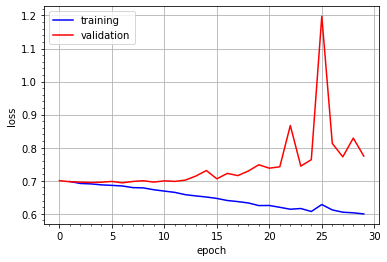

In [73]:
fig,ax = plt.subplots(1,1)
ax.plot(np.arange(len(train_loss_hist))[1:],train_loss_hist[1:],'b',label="training")
ax.plot(np.arange(len(valid_loss_hist)),valid_loss_hist,'r',label="validation")
ax.set_xlabel('epoch')
ax.set_ylabel('loss')
ax.minorticks_on()
ax.grid(b=True)
ax.legend()

In [74]:
valid_sets = []
with torch.no_grad():
    for xv, yv in valid_dl:
        valid_sets.append([cnn_model(xv).detach().cpu().numpy(), yv.detach().cpu().numpy()])

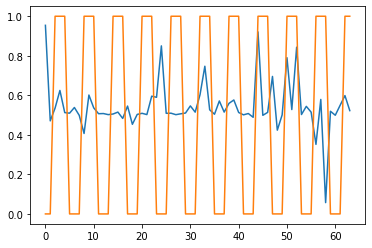

In [75]:
plt.figure()
plt.plot(valid_sets[1][0])
plt.plot(valid_sets[1][1])

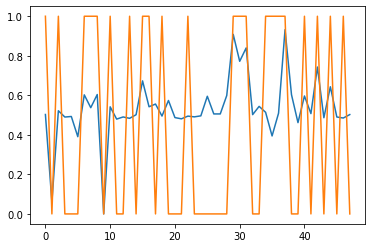

In [76]:
plt.figure()
plt.plot(pred.detach().cpu().numpy())
plt.plot(yb.detach().cpu().numpy())

In [47]:
h_ds

<xarray.Dataset>
Dimensions:         (hologram_number: 50000, particle: 500000, patch_number: 800000, patch_xsize: 128, patch_ysize: 128, xsize: 512, ysize: 512)
Dimensions without coordinates: hologram_number, particle, patch_number, patch_xsize, patch_ysize, xsize, ysize
Data variables: (12/16)
    hid             (particle) float32 1.0 1.0 1.0 1.0 ... 5e+04 5e+04 5e+04
    d               (particle) float32 ...
    x               (particle) float32 ...
    y               (particle) float32 ...
    z               (particle) float32 5.645e+04 1.438e+05 ... 1.419e+05
    n0              (particle) float32 ...
    ...              ...
    x_pixels        (particle) float32 ...
    y_pixels        (particle) float32 ...
    pid             (particle) float32 ...
    x_patch_pixels  (particle) float32 ...
    y_patch_pixels  (particle) float32 ...
    patch           (patch_number, patch_xsize, patch_ysize) uint8 ...
Attributes: (12/33)
    DateCreated:           10-Feb-2021
    Nx:                    512.0
    Ny:                    512.0
    dx:                    2.96e-06
    dy:                    2.96e-06
    lambda:                3.55e-07
    ...                    ...
    monodisperse:          0.0
    should_cache:          1
    Nx_patch:              128.0
    Ny_patch:              128.0
    nPatches:              800000.0
    PatchesPerHologram:    16.0